In [1]:
from pydriller import Repository
import pandas as pd
from tqdm import tqdm
import subprocess

In [2]:
df = pd.DataFrame(columns=["old_path", "new_path", "commit SHA", "parent commit SHA", "commit message", "diff_myers", "diff_hist"])


In [3]:
url = "messages"
count = 0
for commit in Repository(url).traverse_commits():
    # print(commit.hash)
    count += 1
print(f"Total commits: {count}")


Total commits: 1863


In [4]:
total_files = sum(len(commit.modified_files) for commit in Repository(url).traverse_commits())

In [5]:
print(total_files)

5830


In [6]:
df_list = []

In [7]:
df_list.clear()  # Clear the list before starting
pbar = tqdm(total=total_files, desc="Processing files")
repo_local_path = url
for commit in Repository(url).traverse_commits():
    for file in commit.modified_files:
        # Skip files with no parent (initial commit)
        if not commit.parents:
            continue
        parent_sha = commit.parents[0] if commit.parents else None
        commit_sha = commit.hash
        file_path = file.new_path or file.old_path  # Use whichever is not None

        # Construct the git diff commands
        cmd_myers = [
            'git', 'diff', '--text', '--diff-algorithm=myers', '-w', '--ignore-blank-lines',
            parent_sha, commit_sha, '--', file_path
        ]
        cmd_hist = [
            'git', 'diff', '--text', '--diff-algorithm=histogram', '-w', '--ignore-blank-lines',
            parent_sha, commit_sha, '--', file_path
        ]

        # Run the commands and get output
        try:
            diff_myers = subprocess.check_output(cmd_myers, cwd=repo_local_path).decode('utf-8', errors = 'replace')
        except subprocess.CalledProcessError:
            diff_myers = ""
        try:
            diff_hist = subprocess.check_output(cmd_hist, cwd=repo_local_path).decode('utf-8', errors = 'replace')
        except subprocess.CalledProcessError:
            diff_hist = ""

        df_list.append({
            "old_path": file.old_path,
            "new_path": file.new_path,
            "commit_hash": commit.hash,
            "parents": commit.parents,
            "msg": commit.msg,
            "diff_myers": diff_myers,
            "diff_hist": diff_hist,
        })
        pbar.update(1)
pbar.close()


Processing files:   0%|          | 0/5830 [00:00<?, ?it/s]

Processing files:  99%|█████████▉| 5763/5830 [22:14<00:15,  4.32it/s]


In [ ]:
df = pd.DataFrame(df_list)

In [32]:
discrepancy_count = 0
for i, row in df.iterrows():
    if df.loc[i, "diff_myers"] == df.loc[i, "diff_hist"]:
        df.at[i, "Discrepancy"] = "False"
    else:
        discrepancy_count += 1
        df.at[i, "Discrepancy"] = "True"

In [34]:
df.to_csv("messages_proc.csv", index=False)

In [35]:
test_code_df = df[df["old_path"].str.contains("test", case=False, na=False) | df["new_path"].str.contains("test", case=False, na=False)]
readme_df = df[df["old_path"].str.contains("readme", case=False, na=False) | df["new_path"].str.contains("readme", case=False, na=False)]
license_df = df[df["old_path"].str.contains("license", case=False, na=False) | df["new_path"].str.contains("license", case=False, na=False)]
source_df = df[~df.index.isin(test_code_df.index) & ~df.index.isin(readme_df.index) & ~df.index.isin(license_df.index)]

In [36]:
print(len(source_df), "source files")
print(len(test_code_df), "test files")
print(len(readme_df), "readme files")
print(len(license_df), "license files")

4991 source files
674 test files
61 readme files
37 license files


In [37]:
print(len(df))
print(discrepancy_count)

5763
110


In [38]:
# Finding mismatches in all possible types:
print(len(source_df[source_df["Discrepancy"] == "True"]), "mismatches in source files")
print(len(test_code_df[test_code_df["Discrepancy"] == "True"]), "mismatches in test files")
print(len(readme_df[readme_df["Discrepancy"] == "True"]), "mismatches in readme files")
print(len(license_df[license_df["Discrepancy"] == "True"]), "mismatches in license files")

91 mismatches in source files
16 mismatches in test files
3 mismatches in readme files
0 mismatches in license files


In [50]:
df.loc[1, "diff_hist"]

'diff --git a/src/esbuild/parser/parser_test.go b/src/esbuild/parser/parser_test.go\nindex 047c7c79..f1ca56aa 100644\n--- a/src/esbuild/parser/parser_test.go\n+++ b/src/esbuild/parser/parser_test.go\n@@ -831,6 +831,16 @@ func TestMangleIf(t *testing.T) {\n \texpectPrintedMangle(t, "if (!a) {} else throw b", "if (a)\\n  throw b;\\n")\n }\n \n+func TestMangleReturn(t *testing.T) {\n+\texpectPrintedMangle(t, "function foo() { a = b; if (a) return; if (b) c = b; return c; }",\n+\t\t"function foo() {\\n  return a = b, a ? void 0 : (b && (c = b), c);\\n}\\n")\n+}\n+\n+func TestMangleThrow(t *testing.T) {\n+\texpectPrintedMangle(t, "function foo() { a = b; if (a) throw a; if (b) c = b; throw c; }",\n+\t\t"function foo() {\\n  throw a = b, a ? a : (b && (c = b), c);\\n}\\n")\n+}\n+\n func TestTrimCodeInDeadControlFlow(t *testing.T) {\n \texpectPrintedMangle(t, "if (1) a(); else { ; }", "a();\\n")\n \texpectPrintedMangle(t, "if (1) a(); else { b() }", "a();\\n")\n'

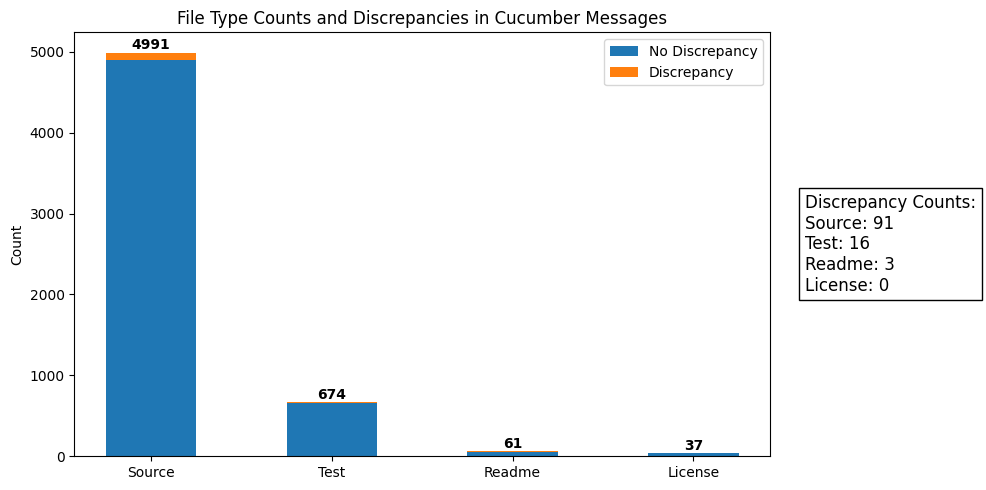

In [41]:
import matplotlib.pyplot as plt
total_counts = [len(source_df), len(test_code_df), len(readme_df), len(license_df)]
discrepancy_counts = [len(source_df[source_df["Discrepancy"] == "True"]), len(test_code_df[test_code_df["Discrepancy"] == "True"]), len(readme_df[readme_df["Discrepancy"] == "True"]), len(license_df[license_df["Discrepancy"] == "True"])]
categories = ['Source', 'Test', 'Readme', 'License']
x = range(len(categories))

plt.figure(figsize=(10,5))
plt.bar(x, [t-d for t, d in zip(total_counts, discrepancy_counts)], width=0.5, label='No Discrepancy')
plt.bar(x, discrepancy_counts, width=0.5, bottom=[t-d for t, d in zip(total_counts, discrepancy_counts)], label='Discrepancy')

for i in x:
    plt.text(i, total_counts[i]+0.5, str(total_counts[i]), ha='center', va='bottom', fontweight='bold')
    # if discrepancy_counts[i] > 0:
        # plt.text(i, total_counts[i]-discrepancy_counts[i]/2, str(discrepancy_counts[i]), ha='center', va='center', color='white', fontweight='bold')

# Add textbox on the right
discrepancy_text = "\n".join([f"{cat}: {count}" for cat, count in zip(categories, discrepancy_counts)])
plt.gca().text(1.05, 0.5, f"Discrepancy Counts:\n{discrepancy_text}", transform=plt.gca().transAxes,
               fontsize=12, verticalalignment='center', bbox=dict(facecolor='white', edgecolor='black'))

plt.xticks(x, categories)
plt.ylabel('Count')
plt.title('File Type Counts and Discrepancies in Cucumber Messages')
plt.legend()
plt.tight_layout()
plt.show()
